# Load the dataset and split

<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/v2.0/notebooks/feature_importance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/v2.0/notebooks/feature_importance.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP and ICARlearn from GitHub
Skip this cell if you alread have installed HELP.

In [ ]:
!pip install -q git+https://github.com/giordamaug/HELP.git
!pip install -q git+https://github.com/giordamaug/ICARlearn.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from Zenodo [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.12620877.svg)](https://doi.org/10.5281/zenodo.12620877)
 the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs.csv`).  

Skip this step if you already have these input files locally.

In [1]:
from HELPpy.utility.utils import pdread_csv_fromurl
tissue='Kidney'
X_bio = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_BIO.csv", index_col=0)
X_cccfs = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_CCcfs.csv", index_col=0)
Y = pdread_csv_fromurl(f"https://zenodo.org/records/12620877/files/{tissue}_HELP.csv", index_col=0)

### 3. Pre-processing and merge input files
We apply pre-processing only to the BIO and CCcfs attributes.
+ constant attributes removal, and
+ data scaling with z-score.  

We also replace `E` label (positive label) and `aE` and `sNE` labels as 0 label (negative label), to address binary `E vs NE` classification.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df_y = Y.replace({'aE': 0, 'sNE': 0, 'E': 1})              # rename labels to set binary classification E=1, NE=0
print(df_y.value_counts(normalize=False))
def preproc(df):
    consts = df.columns[df.nunique() <= 1].values
    print(f"Removing {len(consts)} constant features ...")
    df = df.drop(consts, axis=1)
    df = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
    return df
X_bio = preproc(X_bio)
X_cccfs = preproc(X_cccfs)
df_X = pd.merge(X_bio, X_cccfs, left_index=True, right_index=True, how='outer')
idxs = np.intersect1d(df_y.index.values, df_X.index.values)
df_X = df_X.loc[idxs]
df_y = df_y.loc[idxs]
dataset = pd.concat([df_X, df_y], axis=1)

label
0        16678
1         1253
Name: count, dtype: int64
Removing 0 constant features ...
Removing 3 constant features ...


### 4. Feature importance analysis
Create a model with optima hyper-parameters and fit the entire dataset.

In [3]:
from icarlearn.ensemble.splitvotingens import sveLGBM
hparams = {"n_estimators" :200, "n_voters": 13, "learning_rate": 0.1, "boosting_type": "gbdt"}
svelgbm = sveLGBM(**hparams)
svelgbm.fit(df_X,df_y)

sveLGBM(n_voters=13)

Save feature importance scores and plot the features with score greater than 0.001 (i.e. consider only feature contributing with more than 0.1 %)

<Figure size 640x480 with 0 Axes>

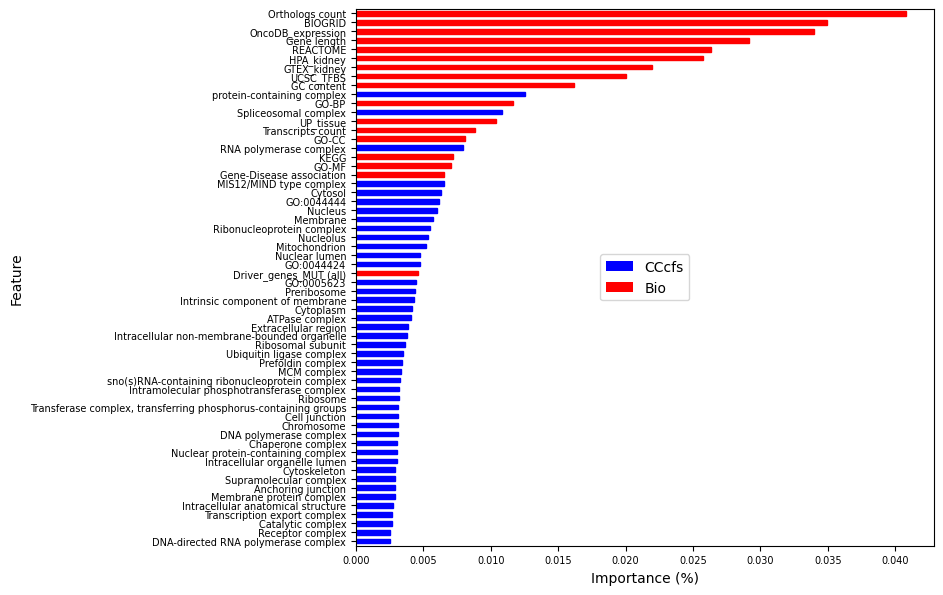

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
plt.tight_layout()
df = pd.DataFrame({'Feature': df_X.columns, 'Importance' : svelgbm.feature_importances_}).sort_values('Importance', ascending=False)
df.to_csv("sveLGBM_feature_importance.csv")
ax = df[df['Importance']>=0.0025].sort_values('Importance', ascending=True).plot.barh(x='Feature', fontsize=7, y='Importance')
fig = ax.get_figure()
fig.tight_layout()
bioattrs = X_bio.columns
for tick, feat in zip(ax.get_children(),ax.get_yticklabels()):
    if feat.get_text() in bioattrs:
        tick.set_color('r')
    else:
        tick.set_color('b')
legend_elements = [ Patch(facecolor='b', label='CCcfs'),Patch(facecolor='r', label='Bio')]
ax.legend(handles=legend_elements, loc='center')
ax.set_xlabel("Importance (%)")
fig.set_size_inches(14, 6)
fig.savefig('sveLGBM_feature_importance.png', dpi=600)

#### Evaluate contribution of Bio attributes

In [15]:
print(f"BIO attributes contribution is {(df[df['Feature'].isin(X_bio.columns)]['Importance'].sum()*100):.1f}%")

0.3143846153846154